In [1]:
%load_ext autoreload
%autoreload 2
# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rc

# mpl.style.use("ggplot")
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib
#matplotlib.rcParams['text.usetex']=True
#matplotlib.rcParams['text.latex.unicode']=True

# rc("text", usetex=True)

# Data

In [2]:
ba_deg_dist_file = "../../data/res-ba-cont/seir/deg-dist.csv"
intb_deg_dist_file = "../../data/res-intb-cont/seir/deg-dist.csv"
dtu_deg_dist_file = "../../data/res-dtu/seir/seir-deg-dist.csv"

In [3]:
def groupby_type(df):
    
    # Find how many nodes are traced by the frequency-based contact tracing 
    nlist = [int(x.split("_")[1]) for x in np.unique(df.type) if "traced_" in x]
    
    # group data by pk, qk, rk
    pk_ccdf = df[df.type == "pk"]
    qk_ccdf = df[df.type == "qk"]
    rk_ccdf = df[df.type == "rk"]
    isolated_ccdf = df[np.isin(df.type,  ["isolated", "infected"])] # no reason for the difference
    parents_ccdf = df[np.isin(df.type,  ["parent", "parents"])] # Yes, I know what you want to say. No reason for the difference. 

    # group data by the frequency for the frequency-based contact tracing
    traced_n_ccdf = {}
    for n in nlist:
        dg = df[df.type == "traced_%d" % n]
        traced_n_ccdf[n] = dg

    # Save the results into plot_data
    plot_data = {}
    plot_data["pk"] = {"label": r"$G_0(x)~ \sim p_k$", "data": pk_ccdf}
    plot_data["qk"] = {"label": r"$G_1(x)~ \sim k p_k$", "data": qk_ccdf}
    plot_data["rk"] = {"label": r"$G_2(x)~ \sim k(k-1) p_k$", "data": rk_ccdf}
    plot_data["infected"] = {"label": r"Infected", "data": isolated_ccdf}
    plot_data["parents"] = {"label": r"Parent", "data": parents_ccdf}
   
    # results for the frequency based contact tracing
    for n in nlist:
        if n < 999:
            plot_data["traced_%d" % n] = {"label": r"Traced, top %d" % n, "data": traced_n_ccdf[n]}
        else:
            plot_data["traced_all"] = {
                "label": r"Traced, all",
                "data": traced_n_ccdf[n],
            }
    return plot_data

plot_data = {}
plot_data["ba"] = groupby_type(pd.read_csv(ba_deg_dist_file, sep="\t"))
plot_data["intb"] = groupby_type(pd.read_csv(intb_deg_dist_file, sep="\t"))
plot_data["dtu"] = groupby_type(pd.read_csv(dtu_deg_dist_file, sep="\t"))

# Plot

## Layout

In [4]:
def set_layout():
    fig = plt.figure(figsize=(20, 8))

    gs_master = GridSpec(
        nrows=2,
        ncols=3,
        # width_ratios=[1, 1, 1],
        hspace=0.1,
        wspace=0.15,
    )

    # label2id = {"back_ct":0, "freq_ct":1, "ba":0, "intb":1, "dtu":2}
    axes = {}
    for i, k in enumerate(["back_ct", "freq_ct"]):
        for j, l in enumerate(["ba", "intb", "dtu"]):
            ax = fig.add_subplot(gs_master[i, j])
            axes[(k, l)] = ax
    return fig, axes

## Test plot

In [5]:
def test_plotter(plotter, ax):

    rc("text", usetex=True)
    sns.set(font_scale=1.3)
    sns.set_style("white")
    sns.set_style("ticks")

    # Set up the layout
    plotter(ax)
    sns.despine()

In [6]:
#
# Set up color map
#
sns.set_style("white")
sns.set(font_scale=1.3)
sns.set_style("ticks")
cmap = sns.color_palette().as_hex()
cmap_reds = ["#EBB799", "#DD8452", "#994B1E"]

#
# Param
#
plot_kwargs = {"ci": 95, "err_style": "band"}

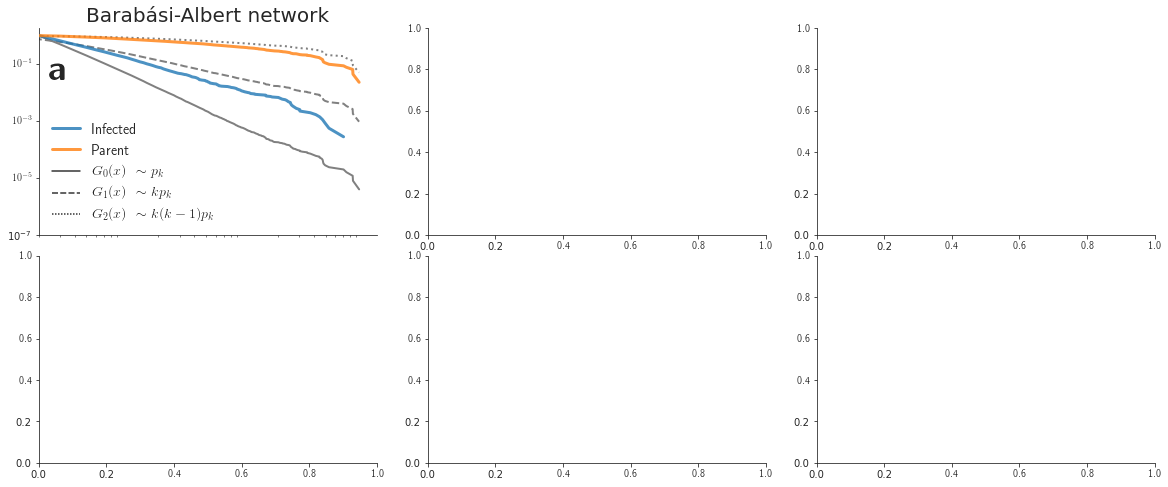

In [7]:
def plot_a(ax):
    #
    # Panel A
    #
    # Plot infected and parents
    for i, label in enumerate(["infected", "parents"]):
        table = plot_data["ba"][label]["data"]
        sns.lineplot(
            data=table,
            x="deg",
            y="prob",
            color=cmap[i],
            linewidth=3,
            alpha=0.8,
            zorder=999,
            ax=ax,
            label=plot_data["ba"][label]["label"],
        )

    # Plot pk, qk, rk lines
    g_tables = []
    for k in ["pk", "qk", "rk"]:
        table = plot_data["ba"][k]["data"]
        table["label"] = plot_data["ba"][k]["label"]
        g_tables += [table]
    g_tables = pd.concat(g_tables, ignore_index=True)
    ax = sns.lineplot(
        data=g_tables,
        x="deg",
        style="label",
        y="prob",
        color=(0.5, 0.5, 0.5),
        linewidth=2,
        ax=ax,
    )
    ax.lines[3].set_linestyle("--")
    ax.lines[4].set_linestyle(":")

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    handles = [x for i, x in enumerate(handles) if i not in [2]]
    labels = [x for i, x in enumerate(labels) if i not in [2]]
    ax.legend(handles=handles, labels=labels, frameon=False)

    # Scale and ticks
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(left=2)
    ax.set_ylim(bottom=1e-7)

    # Annotations and labels
    ax.set_xticks([])
    ax.set_xlabel(r"")
    ax.set_ylabel(r"")
    ax.annotate(
        r"\textbf{a}",
        xy=(0.03, 0.87),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="top",
        weight="bold",
        fontsize=36,
    )

    ax.set_title("Barabási-Albert network", fontsize = 20)

fig, axes = set_layout()
test_plotter(plot_a, axes[("back_ct", "ba")])

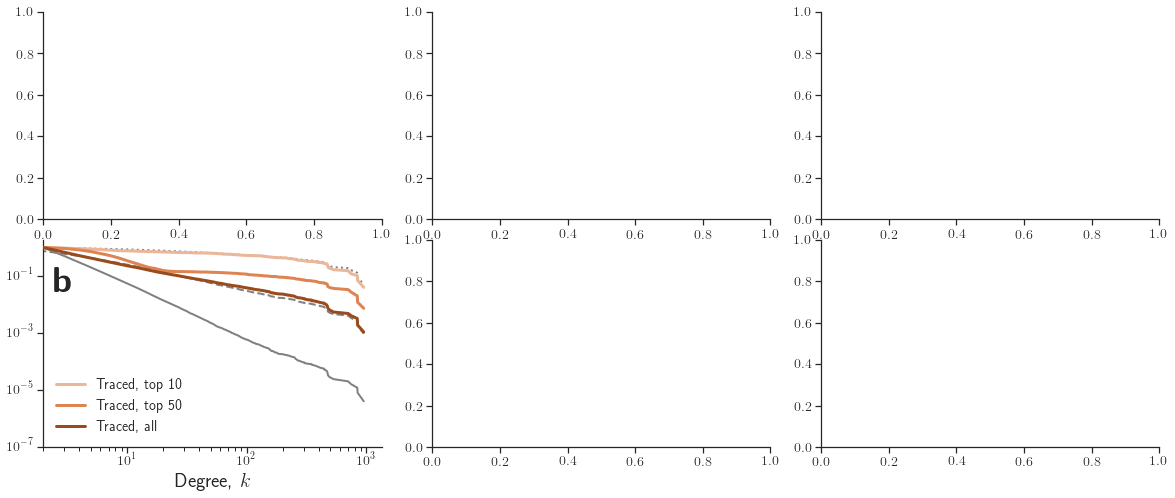

In [8]:
def plot_b(ax):

    for i, label in enumerate(
        ["traced_10", "traced_50", "traced_all"]
    ):
        table = plot_data["ba"][label]["data"]
        sns.lineplot(
            data=table,
            x="deg",
            y="prob",
            color=cmap_reds[i],
            linewidth=3,
            zorder=999,
            ax=ax,
            label=plot_data["ba"][label]["label"],
        )

    # Plot pk, qk, rk lines
    g_tables = []
    for k in ["pk", "qk", "rk"]:
        table = plot_data["ba"][k]["data"]
        table["label"] = plot_data["ba"][k]["label"]
        g_tables += [table]
    g_tables = pd.concat(g_tables, ignore_index=True)

    sns.lineplot(
        data=g_tables,
        x="deg",
        style="label",
        y="prob",
        color=(0.5, 0.5, 0.5),
        linewidth=2,
        ax=ax,
    )
    ax.lines[4].set_linestyle("--")
    ax.lines[5].set_linestyle(":")

    handles, labels = ax.get_legend_handles_labels()
    handles = [x for i, x in enumerate(handles) if i not in [3, 4, 5, 6]]
    labels = [x for i, x in enumerate(labels) if i not in [3, 4, 5, 6]]
    ax.legend(handles=handles, labels=labels, frameon=False)

    # Scale and ticks
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(left=2)
    ax.set_ylim(bottom=1e-7)

    # Annotations and labels
    # Annotations and labels
    ax.set_xlabel(r"Degree, $k$", fontsize = 20)
    ax.set_ylabel(r"")
    #rc("text", usetex=False)
    #ax.set_xlabel(r"")
    #ax.set_ylabel(r"")
    #ax.set_yticklabels([])
    ax.annotate(
        r"\textbf{b}",
        xy=(0.03, 0.87),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="top",
        weight="bold",
        fontsize=36,
    )


fig, axes = set_layout()
test_plotter(plot_b, axes[("freq_ct", "ba")])

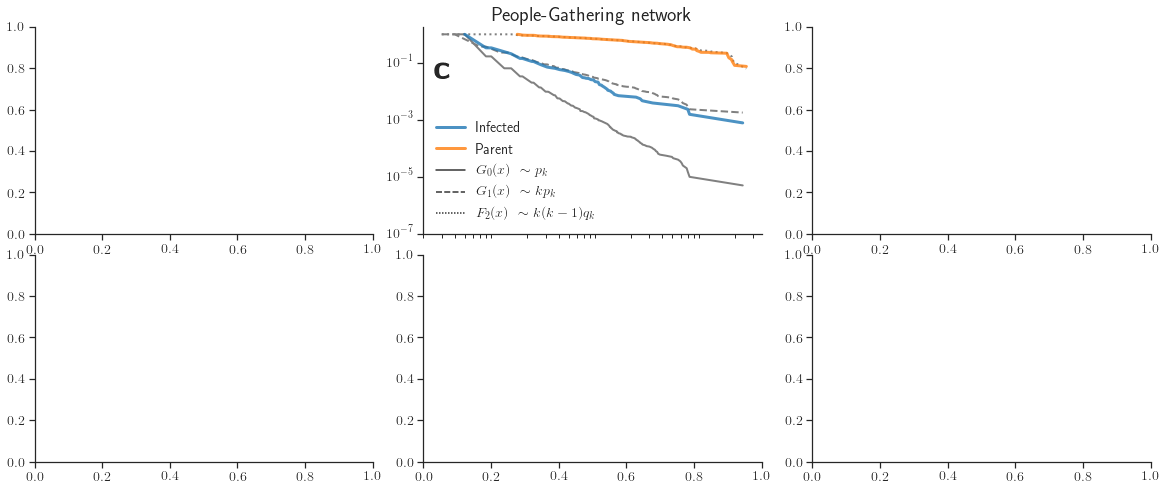

In [9]:
def plot_c(ax):
    #
    # Panel A
    #
    # Plot infected and parents
    rename_labels = {r"$G_2(x)~ \sim k(k-1) p_k$":r"$F_2(x)~ \sim k(k-1) q_k$"}
    
    for i, label in enumerate(["infected", "parents"]):
        table = plot_data["intb"][label]["data"]
        sns.lineplot(
            data=table,
            x="deg",
            y="prob",
            color=cmap[i],
            linewidth=3,
            alpha=0.8,
            zorder=999,
            ax=ax,
            label= plot_data["intb"][label]["label"],
        )

    # Plot pk, qk, rk lines
    g_tables = []
    for k in ["pk", "qk", "rk"]:
        table = plot_data["intb"][k]["data"]
        table["label"] = rename_labels.get( plot_data["intb"][k]["label"], plot_data["intb"][k]["label"] )
        g_tables += [table]
    g_tables = pd.concat(g_tables, ignore_index=True)
    ax = sns.lineplot(
        data=g_tables,
        x="deg",
        style="label",
        y="prob",
        color=(0.5, 0.5, 0.5),
        linewidth=2,
        ax=ax,
    )
    ax.lines[3].set_linestyle("--")
    ax.lines[4].set_linestyle(":")

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    handles = [x for i, x in enumerate(handles) if i not in [2]]
    labels = [x for i, x in enumerate(labels) if i not in [2]]
    ax.legend(handles=handles, labels=labels, frameon=False)

    # Scale and ticks
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(left=2)
    ax.set_ylim(bottom=1e-7)

    # Annotations and labels
    ax.set_xticks([])
    ax.set_xlabel(r"")
    ax.set_ylabel(r"")
    ax.annotate(
        r"\textbf{c}",
        xy=(0.03, 0.87),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="top",
        weight="bold",
        fontsize=36,
    )

    ax.set_title("People-Gathering network", fontsize = 20)

fig, axes = set_layout()
test_plotter(plot_c, axes[("back_ct", "intb")])

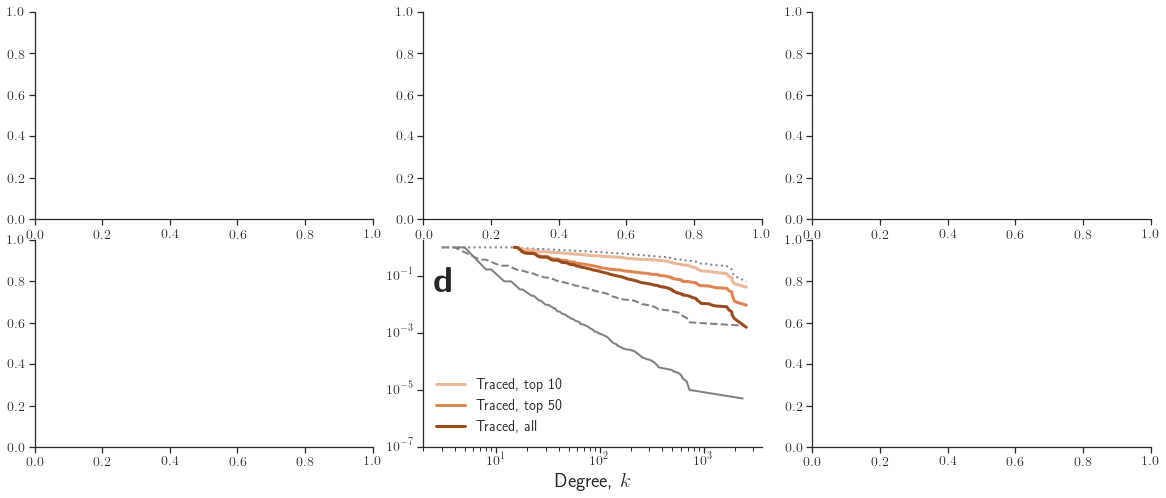

In [10]:
def plot_d(ax):

    for i, label in enumerate(
        ["traced_10", "traced_50", "traced_all"]
    ):
        table = plot_data["intb"][label]["data"]
        sns.lineplot(
            data=table,
            x="deg",
            y="prob",
            color=cmap_reds[i],
            linewidth=3,
            zorder=999,
            ax=ax,
            label=plot_data["intb"][label]["label"],
        )

    # Plot pk, qk, rk lines
    g_tables = []
    for k in ["pk", "qk", "rk"]:
        table = plot_data["intb"][k]["data"]
        table["label"] = plot_data["intb"][k]["label"]
        g_tables += [table]
    g_tables = pd.concat(g_tables, ignore_index=True)

    sns.lineplot(
        data=g_tables,
        x="deg",
        style="label",
        y="prob",
        color=(0.5, 0.5, 0.5),
        linewidth=2,
        ax=ax,
    )
    ax.lines[4].set_linestyle("--")
    ax.lines[5].set_linestyle(":")

    handles, labels = ax.get_legend_handles_labels()
    handles = [x for i, x in enumerate(handles) if i not in [3, 4, 5, 6]]
    labels = [x for i, x in enumerate(labels) if i not in [3, 4, 5, 6]]
    ax.legend(handles=handles, labels=labels, frameon=False)

    # Scale and ticks
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim(left=2)
    ax.set_ylim(bottom=1e-7)

    # Annotations and labels
    # Annotations and labels
    ax.set_xlabel(r"Degree, $k$", fontsize = 20)
    ax.set_ylabel(r"")
    #rc("text", usetex=False)
    #ax.set_xlabel(r"")
    #ax.set_ylabel(r"")
    #ax.set_yticklabels([])
    ax.annotate(
        r"\textbf{d}",
        xy=(0.03, 0.87),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="top",
        weight="bold",
        fontsize=36,
    )


fig, axes = set_layout()
test_plotter(plot_d, axes[("freq_ct", "intb")])

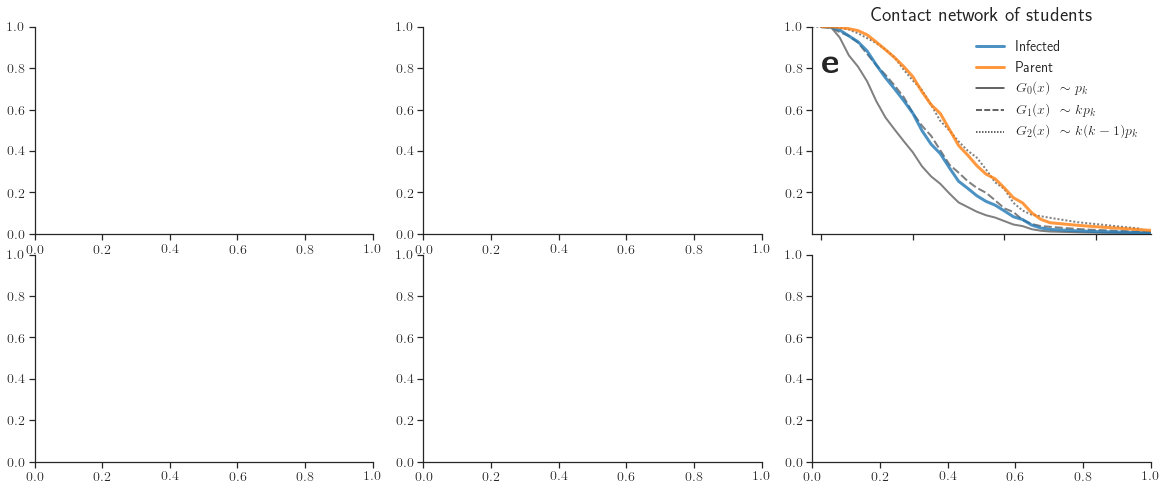

In [11]:
def plot_e(ax):
    for i, label in enumerate(["infected", "parents"]):
        table = plot_data["dtu"][label]["data"]
        ax = sns.lineplot(
            data=table,
            x="deg",
            y="prob",
            color=cmap[i],
            linewidth=3,
            alpha=0.8,
            zorder=999,
            ax=ax,
            label=plot_data["dtu"][label]["label"],
        )

        # Plot pk, qk, rk lines
    g_tables = []
    for k in ["pk", "qk", "rk"]:
        table = plot_data["dtu"][k]["data"]
        table["label"] = plot_data["dtu"][k]["label"]
        g_tables += [table]
    g_tables = pd.concat(g_tables, ignore_index=True)

    ax = sns.lineplot(
        data=g_tables,
        x="deg",
        style="label",
        y="prob",
        color=(0.5, 0.5, 0.5),
        linewidth=2,
        ax=ax,
        #legend=None,
    )
    # ax.lines[2].set_linestyle("--")
    # ax.lines[3].set_linestyle(":")
    handles, labels = ax.get_legend_handles_labels()
    handles = [x for i, x in enumerate(handles) if i not in [2]]
    labels = [x for i, x in enumerate(labels) if i not in [2]]
    ax.legend(handles=handles, labels=labels, frameon=False)

    # Scale and ticks
    ax.set_yscale("linear")
    ax.set_ylabel("")
    ax.set_xlim(left=-1, right = 36)
    ax.set_ylim(bottom=1e-5, top=1)
    ax.set_xlabel(r"", fontsize=20)
    ax.set_xticklabels([])
    ax.annotate(
        r"\textbf{e}",
        xy=(0.03, 0.9),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="top",
        weight="bold",
        fontsize=36,
    )
    ax.set_title("Contact network of students", fontsize = 20)

fig, axes = set_layout()
test_plotter(plot_e, axes[("back_ct", "dtu")])

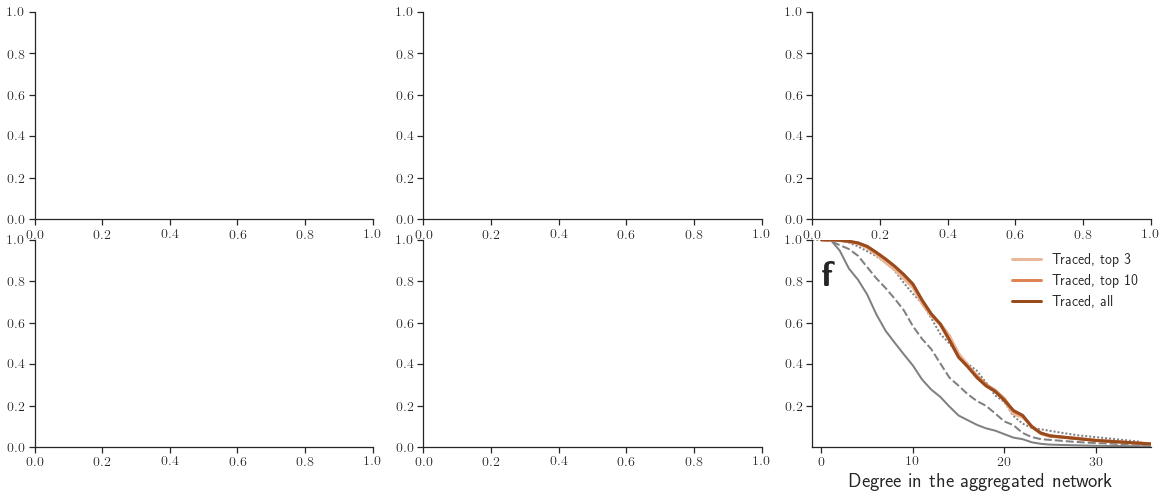

In [12]:
def plot_f(ax):
    for i, label in enumerate(
        ["traced_3", "traced_10", "traced_all"]
    ):
        table = plot_data["dtu"][label]["data"]
        sns.lineplot(
            data=table,
            x="deg",
            y="prob",
            color=cmap_reds[i],
            linewidth=3,
            zorder=999,
            ax=ax,
            label=plot_data["dtu"][label]["label"],
        )
        # Plot pk, qk, rk lines
    g_tables = []
    for k in ["pk", "qk", "rk"]:
        table = plot_data["dtu"][k]["data"]
        table["label"] = plot_data["dtu"][k]["label"]
        g_tables += [table]
    g_tables = pd.concat(g_tables, ignore_index=True)

    ax = sns.lineplot(
        data=g_tables,
        x="deg",
        style="label",
        y="prob",
        color=(0.5, 0.5, 0.5),
        linewidth=2,
        ax=ax,
        legend=None,
    )
    # ax.lines[2].set_linestyle("--")
    # ax.lines[3].set_linestyle(":")

    # Scale and ticks
    ax.set_yscale("linear")
    ax.set_ylabel("")
    ax.set_xlim(left=-1, right = 36)
    ax.set_ylim(bottom=1e-5, top=1)
    ax.legend(frameon=False)
    #ax.set_xlabel(r"", fontsize=20)
    ax.set_xlabel(r"Degree in the aggregated network", fontsize = 20)
    ax.annotate(
        r"\textbf{f}",
        xy=(0.03, 0.9),
        xycoords="axes fraction",
        horizontalalignment="left",
        verticalalignment="top",
        weight="bold",
        fontsize=36,
    )

fig, axes = set_layout()
test_plotter(plot_f, axes[("freq_ct", "dtu")])

# Plot

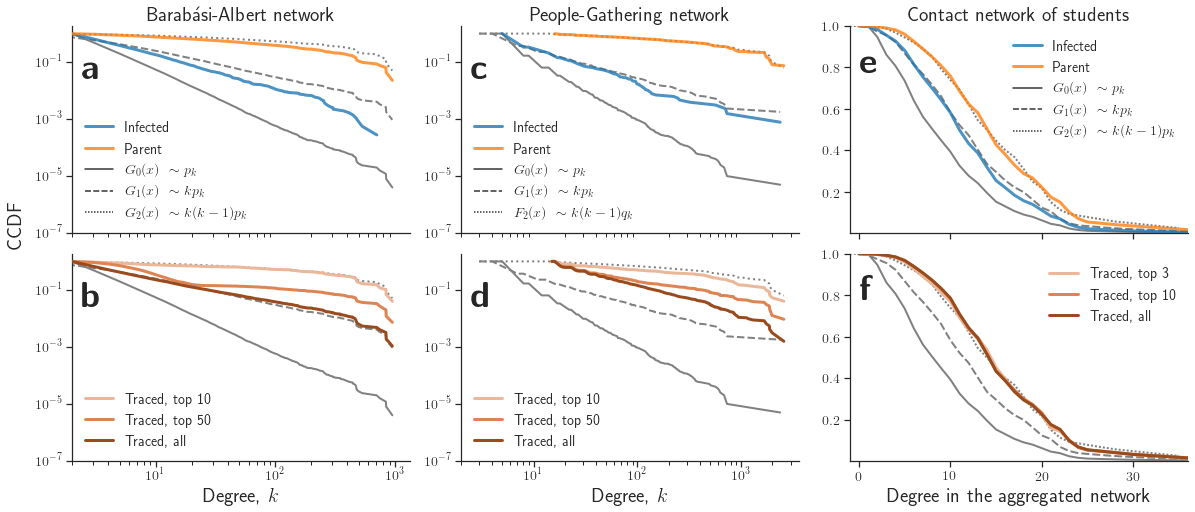

In [13]:
rc("text", usetex=True)
sns.set_style("white")
sns.set(font_scale=1.3)
sns.set_style("ticks")

# Set up the layout
fig, axes = set_layout()
plotter_list = [[plot_a, plot_c, plot_e], [plot_b, plot_d, plot_f]]

for i, k in enumerate(["back_ct", "freq_ct"]):
    for j, l in enumerate(["ba", "intb", "dtu"]):
        plotter_list[i][j](axes[k, l])
fig.text(0.08, 0.5, r"CCDF", rotation = 90, fontsize = 20)
sns.despine()